ideas:
- process all images in dataset and make histogram of image bb names. what are the most common labels?
- critically describe the distribution: long-tailed distribution?
- look at all name replacements from NYU dataset (what objects are being renamed "table" for example? is it just ones already called "table" or is it also "desk", "dining table", etc?)
- maybe also look at object size vs importance -- larger objects may be more important since they dominate visual field?
- can use all of the above info to filter labels (only use most common labels, discard rare ones such as 'rubber duck')

In [2]:
import h5py
import numpy as np
from matplotlib import pyplot as plt
from PIL import Image
import csv
# import networkx as nx
from numpy import genfromtxt
from scipy.spatial import distance
import os
import glob
from pylab import *

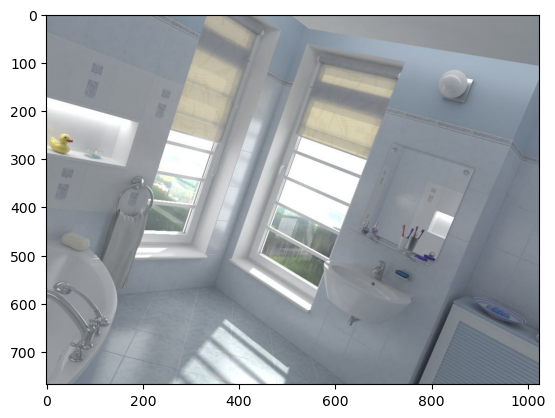

In [3]:
# visualise tonemap for scene 0 (aka cam00), frame 0000
img = Image.open(r"C:\Users\amali\Documents\ds_research\ml-hypersim\contrib\99991\downloads\ai_001_001\images\scene_cam_00_final_preview\frame.0000.tonemap.jpg")
data_img = np.asarray( img, dtype="int32" )
plt.imshow(data_img)

remember to convert to meters rather than scene units below

In [4]:
# load size, orientation and position of 3D bounding boxes from hdf5 files
bb_size_path = r"C:\Users\amali\Documents\ds_research\ml-hypersim\contrib\99991\downloads\ai_001_001\_detail\mesh\metadata_semantic_instance_bounding_box_object_aligned_2d_extents.hdf5"
with h5py.File(bb_size_path, "r") as f: bb_size = f['dataset'][:]

bb_orientation_path = r"C:\Users\amali\Documents\ds_research\ml-hypersim\contrib\99991\downloads\ai_001_001\_detail\mesh\metadata_semantic_instance_bounding_box_object_aligned_2d_orientations.hdf5"
with h5py.File(bb_orientation_path, "r") as f: bb_orientation = f['dataset'][:]

bb_position_path = r"C:\Users\amali\Documents\ds_research\ml-hypersim\contrib\99991\downloads\ai_001_001\_detail\mesh\metadata_semantic_instance_bounding_box_object_aligned_2d_positions.hdf5"
with h5py.File(bb_position_path, "r") as f: bb_position = f['dataset'][:]

mesh_objects_si_path = r"C:\Users\amali\Documents\ds_research\ml-hypersim\evermotion_dataset\scenes\ai_001_001\_detail\mesh\mesh_objects_si.hdf5"
with h5py.File(mesh_objects_si_path, "r") as f: mesh_objects_si = f['dataset'][:]
print(mesh_objects_si.shape)

mesh_objects_sii_path = r"C:\Users\amali\Documents\ds_research\ml-hypersim\evermotion_dataset\scenes\ai_001_001\_detail\mesh\mesh_objects_sii.hdf5"
with h5py.File(mesh_objects_sii_path, "r") as f: mesh_objects_sii = f['dataset'][:]

metadata_objects = genfromtxt(r"C:\Users\amali\Documents\ds_research\ml-hypersim\evermotion_dataset\scenes\ai_001_001\_detail\mesh\metadata_objects.csv", delimiter=None, dtype=str)
print(f"\n metadata_objects shape: {metadata_objects.shape}")

with open(r"C:\Users\amali\Documents\ds_research\ml-hypersim\contrib\99991\downloads\ai_001_001\_detail\metadata_scene.csv", newline='') as csvfile:
    metadata_scene = list(csv.reader(csvfile))
    a2m = float(metadata_scene[1][1]) # asset to meters unit conversion

nyu_labels = genfromtxt(r"C:\Users\amali\Documents\ds_research\ml-hypersim\code\cpp\tools\scene_annotation_tool\semantic_label_descs.csv", delimiter=',', dtype=None, encoding=None, autostrip=True)
print("NYU labels shape: ", nyu_labels.shape)

(1391, 1)

 metadata_objects shape: (1392,)
NYU labels shape:  (41, 5)


In [5]:
bb_position.shape

(56, 3)

In [6]:
type(bb_position)

numpy.ndarray

In [7]:
bb_position_m = bb_position*a2m
bb_position_m = np.delete(bb_position_m, 0, axis=0)
print(bb_position_m.shape)

n_bb = bb_position_m.shape[0]
bb_distances = np.zeros((n_bb, n_bb))

# distance.euclidean(bb_position_m[0,:], bb_position_m[1,:])

for i in range(n_bb):
    for j in range(n_bb):
        bb_distances[i, j] = distance.euclidean(bb_position_m[i, :], bb_position_m[j, :])

distance_threshold = 1.5
distance_mask = bb_distances < distance_threshold # True for objects that are within 1.5m of other objects

(55, 3)


In [8]:
bb_names = []
id_i = np.zeros(np.max(mesh_objects_sii))
for i in range(np.max(mesh_objects_sii)):
    instances = np.where(mesh_objects_sii == i+1)[0]
    id_i[i] = mesh_objects_si[instances[0]]
    # print(int(id_i[i]), nyu_labels[int(id_i[i])][1])
    if id_i[i] == 40 or id_i[i] == 39 or id_i[i] == 38:
        bb_names.append(metadata_objects[instances[0]]) # assign object name to the bounding box when there is no NYU label
    else:
        bb_names.append(nyu_labels[int(id_i[i])][1])
print(f"Number of BBs: {len(bb_names)} \n")
print(f"BB labels: {bb_names}") # relevant labels for each bounding box

Number of BBs: 55 

BB labels: ['floor_tile_obj_152', 'shampoo1_obj_04', 'perfume3_obj_06', 'window2_obj_12', 'cotton_bud_obj_03', 'towel', 'lavatory_paper_obj_03', 'blinds', 'window', 'blinds', 'window', 'lamp', 'decoration1_obj_09', 'toothbrush_obj_01', 'toothbrush_obj_04', 'shampoo2_obj_04', 'tray', 'shelves', 'mirror', 'tape', 'soap_box_obj_01', 'sink', 'cabinet', 'decoration1_obj_08', 'decoration1_obj_07', 'decoration1_obj_02', 'decoration1_obj_06', 'decoration1_obj_01', 'wall_tile_obj_330', 'decoration1_obj_04', 'decoration1_obj_05', 'decoration1_obj_03', 'towel', 'towel', 'toilet', 'bath_tub_obj_03', 'button', 'lavatory_paper_obj_02', 'lamp', 'brush_obj_02', 'wall_cupboard_obj_02', 'door_obj_19', 'door', 'towel', 'towel', 'lamp_obj_04', 'nivea_obj_02', 'towel2_obj_02', 'lamp', 'towel2_obj_01', 'towel', 'bathtub', 'cabinet', 'sponge_01', 'lamp']


In [9]:
# elements of mesh_objects_sii that belong to the 23rd BB
b=6
a = np.where(mesh_objects_sii==b)[0]
print(a) # this is a list of all the low-level objects that belong to the 23rd BB
         # ***

# now for every single one of these indeces, look up their semantic label in mesh_objects_si
# (they should all be the same so the first index of the list should be sufficient, double check this)
print(mesh_objects_si[a[0]]) # this is the semantic label of these low-level objects
np.where(mesh_objects_si==mesh_objects_si[a[0]])[0] # this should be the same as ***, plus maybe some extra elements
# mesh_objects_si[2]

[692]
[27]


array([  7,  12,  14,  15, 692, 693], dtype=int64)

In [10]:
metadata_objects

array(['object_name', 'toilet_bowl', 'ceiling', ..., 'nail_polish_obj_01',
       'nail_polish_obj_02', 'nail_polish_obj_03'], dtype='<U21')

[[-1 -1 -1 ... -1 -1 -1]
 [-1 -1 -1 ... -1 -1 -1]
 [-1 -1 -1 ... -1 -1 -1]
 ...
 [52 52 52 ... 23 23 23]
 [52 52 52 ... 23 23 23]
 [52 52 52 ... 23 23 23]]


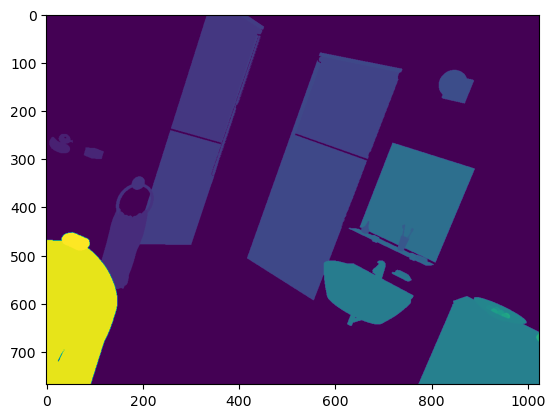

In [11]:
# load semantic segmentation from hdf5 file
seg_inst_path = r"C:\Users\amali\Documents\ds_research\ml-hypersim\contrib\99991\downloads\ai_001_001\images\scene_cam_00_geometry_hdf5\frame.0000.semantic_instance.hdf5"

with h5py.File(seg_inst_path, "r") as f: seg_arr = f['dataset'][:]

print(seg_arr)
plt.imshow(seg_arr)

In [12]:
# these are the BB that actually appear in the image!
unique(seg_arr)

array([-1,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19,
       20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 34, 52, 54],
      dtype=int16)

## 3D->2D project of BB centre for cam_00, frame.0000

In [13]:
# for all files -- ignore for now
in_rgb_jpg_files = r"C:\Users\amali\Documents\ds_research\ml-hypersim\contrib\99991\downloads\ai_001_001\images\scene_cam_00_final_preview\frame.*.tonemap.jpg"
in_filenames = [ os.path.basename(f) for f in sorted(glob.glob(in_rgb_jpg_files)) ]
for in_filename in in_filenames:
    in_filename_ids = [int(t) for t in in_filename.split(".") if t.isdigit()]
    frame_id = in_filename_ids[0]

In [14]:
from matplotlib.pyplot import imread

# import the image we will map BB centres onto
rgb_color = imread(r"C:\Users\amali\Documents\ds_research\ml-hypersim\contrib\99991\downloads\ai_001_001\images\scene_cam_00_final_preview\frame.0000.tonemap.jpg")
height_pixels = rgb_color.shape[0] 
width_pixels  = rgb_color.shape[1]

# import camera positions+orientations files
camera_positions_path = r"C:\Users\amali\Documents\ds_research\ml-hypersim\contrib\99991\downloads\ai_001_001\_detail\cam_00\camera_keyframe_positions.hdf5"
with h5py.File(camera_positions_path, "r") as f: camera_positions = f['dataset'][:]
camera_orientations_path = r"C:\Users\amali\Documents\ds_research\ml-hypersim\contrib\99991\downloads\ai_001_001\_detail\cam_00\camera_keyframe_orientations.hdf5"
with h5py.File(camera_orientations_path, "r") as f: camera_orientations = f['dataset'][:]


# projection matrix cam -> world:
camera_orientation = camera_orientations[0]
camera_position = camera_positions[0]
R_world_from_cam = matrix(camera_orientation)
t_world_from_cam = matrix(camera_position).T
R_cam_from_world = R_world_from_cam.T
t_cam_from_world = -R_cam_from_world*t_world_from_cam

# fov_x and fov_y need to match the _vray_user_params.py that was used to generate the images
# M is the projection matrix that maps from camera view to clip view (ie. normalises camera view)
fov_x = pi/3.0
fov_y = 2.0 * arctan(height_pixels * tan(fov_x/2.0) / width_pixels)
near = 1.0
far = 1000.0

f_h    = tan(fov_y/2.0)*near # focal length in h??
f_w    = f_h*width_pixels/height_pixels
left   = -f_w
right  = f_w
bottom = -f_h
top    = f_h

M_proj      = matrix(zeros((4,4)))
M_proj[0,0] = (2.0*near)/(right - left)
M_proj[1,1] = (2.0*near)/(top - bottom)
M_proj[0,2] = (right + left)/(right - left)
M_proj[1,2] = (top + bottom)/(top - bottom)
M_proj[2,2] = -(far + near)/(far - near)
M_proj[3,2] = -1.0
M_proj[2,3] = -(2.0*far*near)/(far - near)

In [15]:
def transform_point_screen_from_world(p_world):
    # projection matrix for: from P_world to P_cam
    p_cam      = t_cam_from_world + R_cam_from_world*p_world
    p_cam_     = matrix(r_[ p_cam.A1, 1 ]).T
    p_clip     = M_proj*p_cam_
    # projection matrix for: from P_world to P_ndc
    p_ndc      = p_clip/p_clip[3]
    p_ndc_     = p_ndc.A1
    p_screen_x = 0.5*(p_ndc_[0]+1)*(width_pixels-1)
    p_screen_y = (1 - 0.5*(p_ndc_[1]+1))*(height_pixels-1)
    p_screen_z = (p_ndc_[2]+1)/2.0 # why is there a z-component in screen coords?
    p_screen   = matrix([p_screen_x, p_screen_y, p_screen_z]).T
    return p_screen

In [16]:
bb_names[34]

'toilet'

window2_obj_12
[[31.75087214]] [[266.68814325]]


Text([[31.75087214]], [[266.68814325]], 'window2_obj_12')

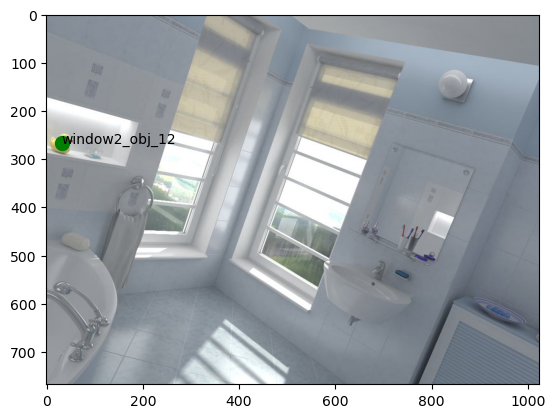

In [17]:
# BB 6 is a towel, 19 is mirror, 8 is left blinds, 22 is sink
# note all BB might not be visible in a given image
# need to filter BB for each image
id=4 # bb_id
print(bb_names[id-1])
bb_centre = expand_dims(bb_position[id], 1)
centre = transform_point_screen_from_world(bb_centre)
# print(centre)
x=centre[0]
y=centre[1]
print(x,y)

plt.imshow(rgb_color)
plt.plot(x, y, "og", markersize=10) #note this is not the best way to plot for multiple points
plt.text(x, y, bb_names[id-1])